In [18]:
# load CSS theme
from IPython.core.display import HTML
HTML(open('/Users/oosoba/.jupyter/custom/dark.css', 'r').read())

In [254]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns
import os, re, json, csv
#import igraph as ig
import networkx as nx
import pprint


%matplotlib inline 
from pylab import rcParams
rcParams['figure.figsize'] = 7,4 # Bigger figures
rcParams['lines.linewidth'] = 2.0
rcParams.update({'font.size': 25}) # Bigger text (for labels)
#from warnings import filterwarnings #filterwarnings('ignore')

## Ancillary Functions

In [171]:
def FixedPointList(func, arg, nmax = 1000):
    tmp_lst = [func(arg)]
    tmp_lst = tmp_lst + [func(tmp_lst[-1])]
    while ( (len(tmp_lst)==len(set(tmp_lst))) & (len(tmp_lst) < nmax) ):
        tmp_lst = tmp_lst + [func(tmp_lst[-1])]
    return(tmp_lst)

def FixedPoint(func, arg, nmax = 1000):
    return( FixedPointList(func, arg, nmax)[-1] )

def NestWhileList(func, arg, stopTestQ, nmax = 1000):
    # stopTestQ takes full FP list to calc stop flag. stop when True
    tmp_lst = [func(arg)]
    tmp_lst = tmp_lst + [func(tmp_lst[-1])]
    while ( not(stopTestQ(tmp_lst)) & (len(tmp_lst) < nmax) ):
        tmp_lst = tmp_lst + [func(tmp_lst[-1])]
    return([list(t) for t in tmp_lst])


In [245]:
S = lambda x: 1*(x>=0.5) 
#S = lambda x: 1/(1+np.exp(-(9*x-3)))
# delayed unitstep activation function... 
# generalize later: non-decreasing bijections on the unit interval

def Clamp(actvn, mask):
    assert(len(actvn) == len(mask))
    clamped = actvn
    clamped[ [j for j in range(len(mask)) if mask[j]==1] ] = 1
    clamped[ [j for j in range(len(mask)) if mask[j]<0] ] = 0
    return clamped

def dec2binList(x):
    return [int(k) for k in list(bin(x)[2:])]

def ClampIntInt(actvn, on, off):
    return Clamp(actvn, dec2binList(on), dec2binList(off))

def FCMPass(grph, inp, mask):
    assert(len(inp) == len(mask))
    return Clamp( S(
            np.asarray(np.matmul(Clamp(inp, mask), nx.adjacency_matrix(grph).todense())).ravel()
        ), mask)

In [185]:
def stopcritQ(res_lst):
    res_lst = [str(t) for t in res_lst]
    return( len(set(res_lst))!=len(res_lst) )

def FCMEvolSeq(grph, inp, mask, nmax = 1000):
    assert(len(inp) == len(mask))
    seq = NestWhileList(
        lambda inp_vec: FCMPass(grph, inp_vec, mask),
        inp, stopcritQ, nmax
    )
    seq = [inp] + seq
    return(np.matrix(seq))

## Setting Up FCM Graph Framework

FCMs are networkx DiGraphs with weighted edges. Adjacency matrices for these give the FCM connection matrices.

init: fcm = nx.DiGraph()

load edges: fcm.add_weighted_edges_from(csv_list)

load labels:  fcm = nx.relabel_nodes(fcm, map_dict, copy=False)

[[ 0  1  1  0  0  0  0  1  1]
 [ 0  0  1  0  0  0  0  1  0]
 [ 0  0  0  1  0 -1  0  1  1]
 [ 0  0  0  0  0  1  1  0 -1]
 [ 0 -1 -1  0  0  1  1  0  0]
 [ 0  0  0  1  0  0 -1 -1  0]
 [ 0  0  0  0  1  0  0 -1  0]
 [ 0  0  0  0  0  0 -1  0  0]
 [ 0  0  0  0 -1  0  0  1  0]]


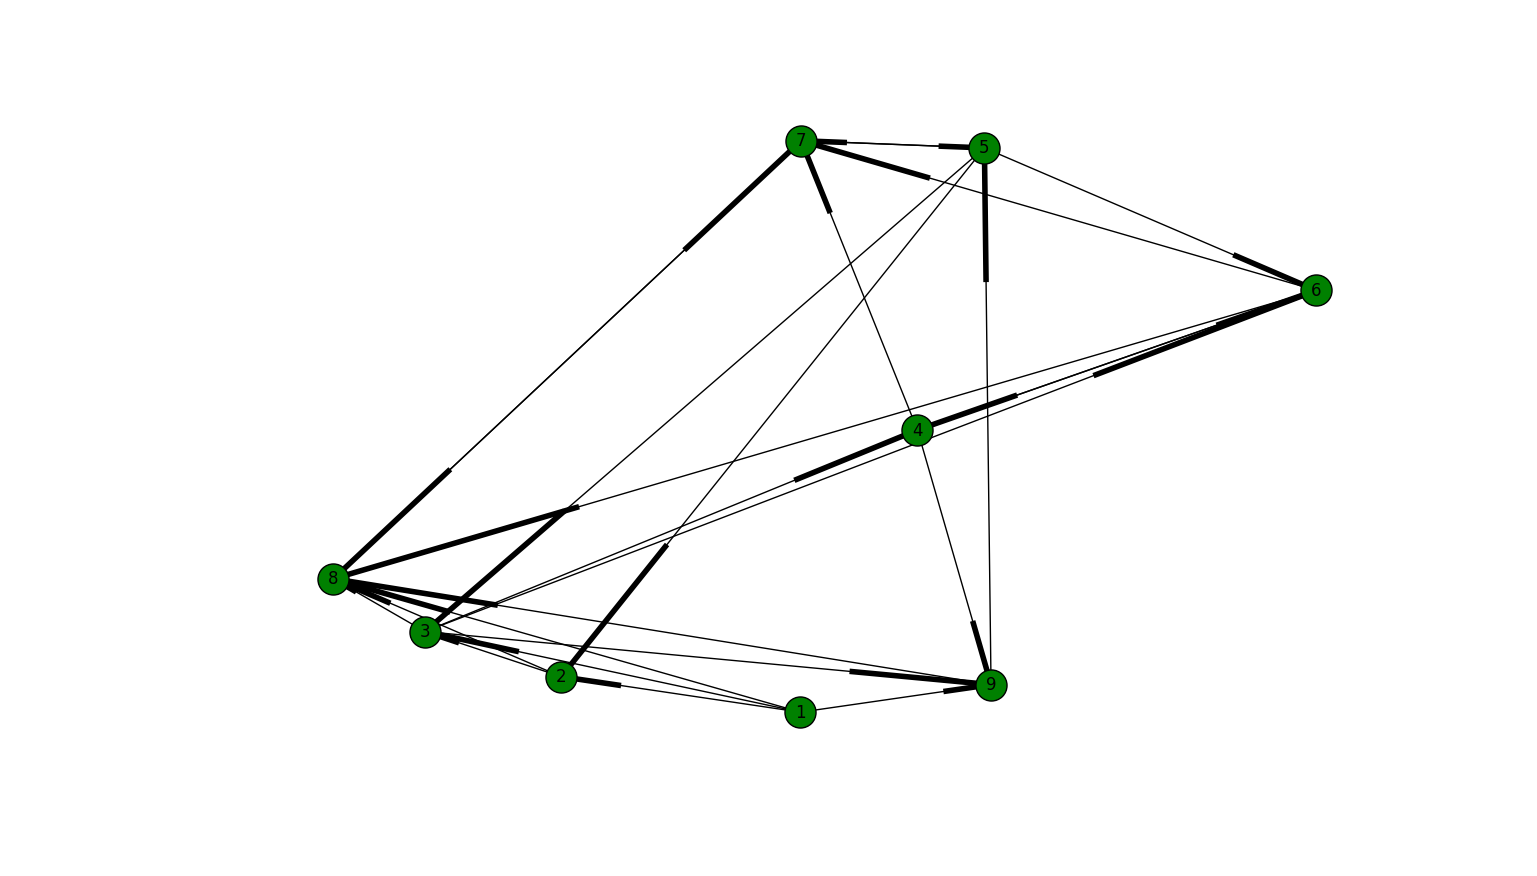

In [100]:
apthdlist = [(1, 2, 1), (1, 3, 1), (1, 8, 1), (2, 3, 1), 
            (3, 4, 1), (3, 6, -1), (3, 8, 1), (3, 9, 1), 
            (4, 6, 1), (4, 7, 1), (4, 9, -1), (5, 2, -1), 
            (5, 3, -1), (5, 6, 1), (5, 7, 1), (6, 4, 1), 
            (6, 7, -1), (6, 8, -1), (7, 5, 1), (7, 8, -1), 
            (8, 7, -1), (9, 5, -1), (9, 8, 1), (2, 8, 1), (1, 9, 1)
           ]
apthdG = nx.DiGraph()
apthdG.add_weighted_edges_from(apthdlist)
nx.draw(apthdG, node_size=500, with_labels=True, node_color='g')
apthdmat = nx.adjacency_matrix(apthdG).todense()
print apthdmat

['HCP', 'stas', 'ADP', 'inju', 'HCF', 'cox', 'aspi', 'war', 'A2', 'clop', 'K', 'PAgg']
[[ 1.    0.4   0.    1.    1.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.5   0.    0.    0.    0.    0.    0.    0.    0.45]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.45]
 [ 0.    0.4   0.    0.    0.75  0.    0.    0.    0.    0.    0.    0.4 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.4 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.95  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.   -0.6   0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.9   0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.95]
 [ 0.    0.   -0.6   0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.  ]
 [ 0.    0.7   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]


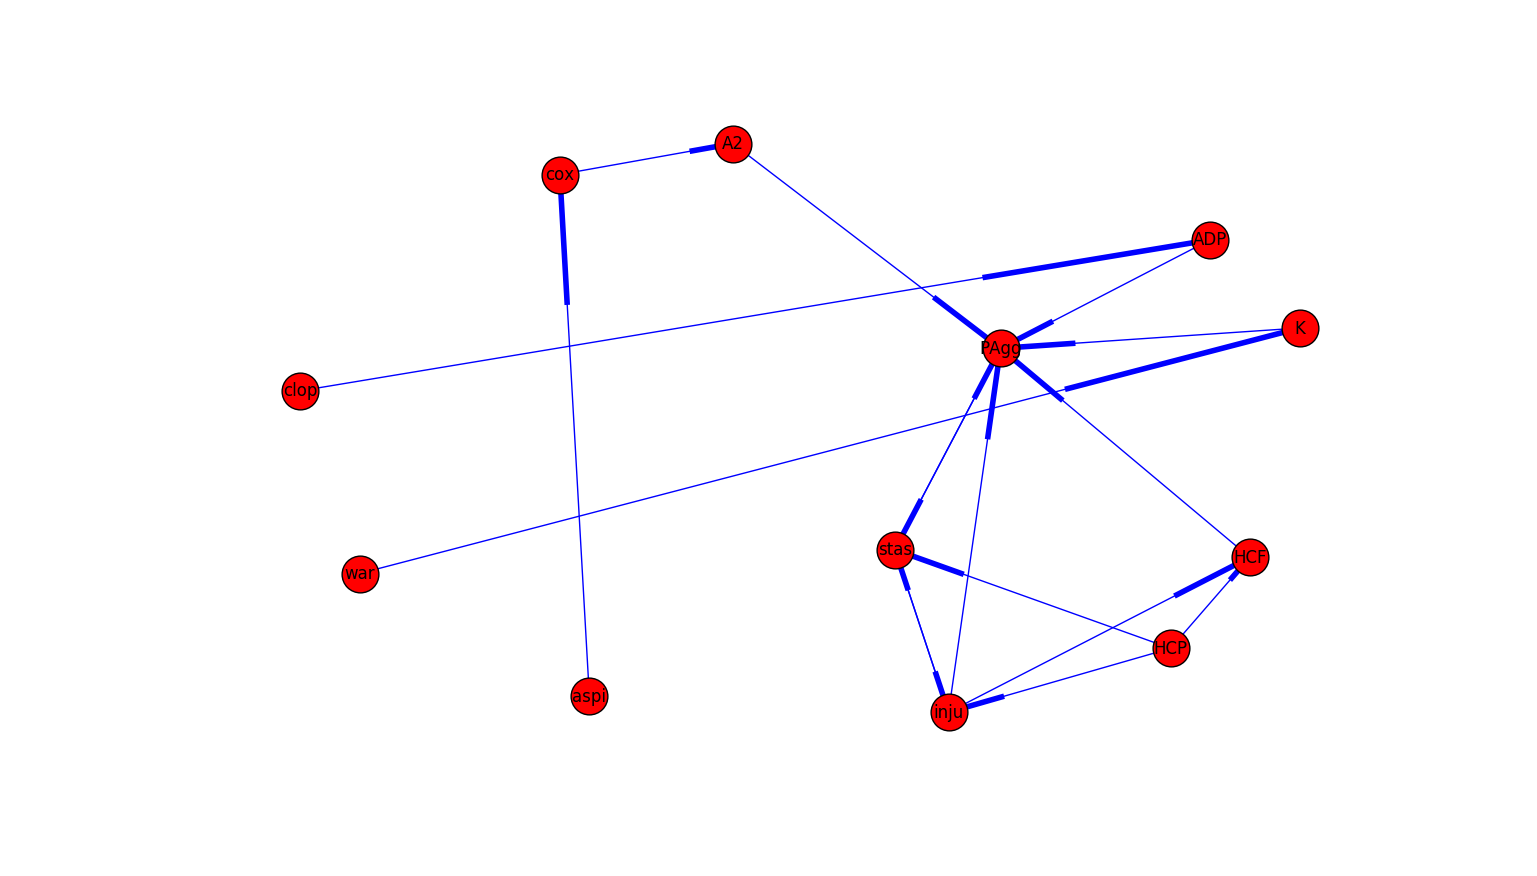

In [101]:
clotlist = [(1, 1, 1), (1, 2, 0.4), (1, 3, 1), (1, 4, 1),
            (2, 3, 0.5), (2, 6, 0.45), (3, 2, 0.4), (3, 4, 0.75),
            (3, 6, 0.4), (4, 6, 0.4), (5, 6, 0.45), (6, 2, 0.7),
            (7, 5, -0.6), (8, 6, 0.95), (9, 10, -0.9), (10, 6, 1),
            (11, 8, 0.95), (12, 11, -0.6)]

clotG = nx.DiGraph()
clotG.add_weighted_edges_from(clotlist)
#nx.draw(clotG, with_labels=True, pos=nx.spectral_layout(G),node_size=500, nodecolor='g', edge_color='b')

mapping = {1:"HCP", 2:"stas", 3:"inju", 
           4:"HCF", 5:"ADP", 6:"PAgg", 
           7:"clop", 8:"A2", 9:"war", 
           10:"K", 11:"cox", 12:"aspi"}
clotG = nx.relabel_nodes(clotG, mapping, copy=False)
print(clotG.nodes())
nx.draw(clotG, with_labels=True, node_size=700, nodecolor='g', edge_color='b')#, pos=nx.spectral_layout(G))

clotmat = nx.adjacency_matrix(clotG).todense()
print clotmat

In [259]:
vec = np.random.randint(2, size=len(clotG.nodes()) )
print vec #print clotmat
print np.matmul(vec, clotmat)

S = lambda x: 1/(1+np.exp(-(9*x-3)))
S = lambda x: 1*(x>=0.5) 
print FCMPass(clotG, inp = vec, mask = np.zeros(len(vec)) )
print ( FCMEvolSeq(clotG, inp = vec, mask = np.zeros(len(vec)) ) )


[0 0 1 1 1 0 0 0 1 0 1 0]
[[ 0.    0.4   0.    0.    0.75  0.    0.    0.    0.    0.    0.    3.2 ]]
[0 0 0 0 1 0 0 0 0 0 0 1]
[[0 0 1 1 1 0 0 0 1 0 1 0]
 [0 0 0 0 1 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


In [ ]:
clotlist = [(1, 1, 1), (1, 2, 0.4), (1, 3, 1), (1, 4, 1),
            (2, 3, 0.5), (2, 6, 0.45), (3, 2, 0.4), (3, 4, 0.75),
            (3, 6, 0.4), (4, 6, 0.4), (5, 6, 0.45), (6, 2, 0.7),
            (7, 5, -0.6), (8, 6, 0.95), (9, 10, -0.9), (10, 6, 1),
            (11, 8, 0.95), (12, 11, -0.6)]

clotG = nx.DiGraph()
clotG.add_weighted_edges_from(clotlist)
#nx.draw(clotG, with_labels=True, pos=nx.spectral_layout(G),node_size=500, nodecolor='g', edge_color='b')

mapping = {1:"HCP", 2:"stas", 3:"inju", 
           4:"HCF", 5:"ADP", 6:"PAgg", 
           7:"clop", 8:"A2", 9:"war", 
           10:"K", 11:"cox", 12:"aspi"}
clotG = nx.relabel_nodes(clotG, mapping, copy=False)
print(clotG.nodes())
nx.draw(clotG, with_labels=True, node_size=700, nodecolor='g', edge_color='b')#, pos=nx.spectral_layout(G))

clotmat = nx.adjacency_matrix(clotG).todense()
print clotmat

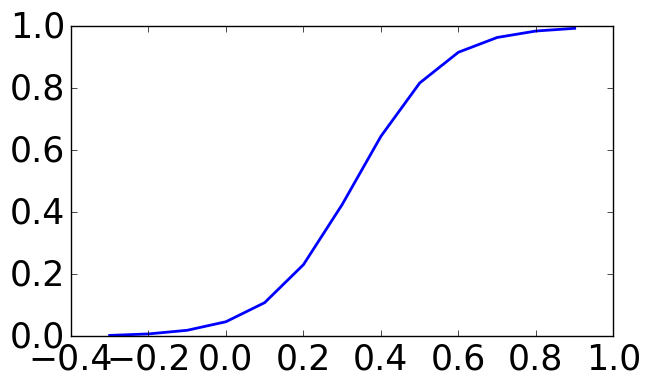

In [243]:
logit = lambda x: 1/(1+np.exp(-x))
plt.plot(np.arange(-0.3,1, 0.1), S(np.arange(-0.3,1, 0.1)) )

### Dev Stubs

In [126]:
samp = lambda x: sp.cos(x)
sqt = lambda x: (x + 2/x)/2
#print samp(0.5)

res = FixedPointList(samp, 0.5)
print [len(res), res[-10:]]


res = FixedPointList(sqt, 1.)
print [len(res), res[-10:]]

print FixedPoint( sp.log, complex(1,1) )
FixedPointList( sp.log, complex(1,1) )[-5:]

[90, [0.73908513321516334, 0.73908513321515878, 0.73908513321516189, 0.73908513321515978, 0.73908513321516123, 0.73908513321516023, 0.73908513321516089, 0.73908513321516045, 0.73908513321516078, 0.73908513321516045]]
[6, [1.5, 1.4166666666666665, 1.4142156862745097, 1.4142135623746899, 1.414213562373095, 1.414213562373095]]
(0.318131505205+1.33723570143j)


[(0.31813150520476424+1.3372357014306893j),
 (0.31813150520476408+1.3372357014306893j),
 (0.31813150520476402+1.3372357014306895j),
 (0.31813150520476419+1.3372357014306895j),
 (0.31813150520476419+1.3372357014306895j)]

In [137]:
print stopcritQ([[1,2,3], [1,3,4]])
print stopcritQ([[1,2,3], [1,3,4],[1,2,3]])

False
True


In [99]:
%%time
def test(*args):
    print [a for a in args]

[test(1,2,3),5]

[1, 2, 3]
CPU times: user 116 µs, sys: 37 µs, total: 153 µs
Wall time: 132 µs


[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
[[0 1 1]
 [0 0 1]
 [0 0 1]]


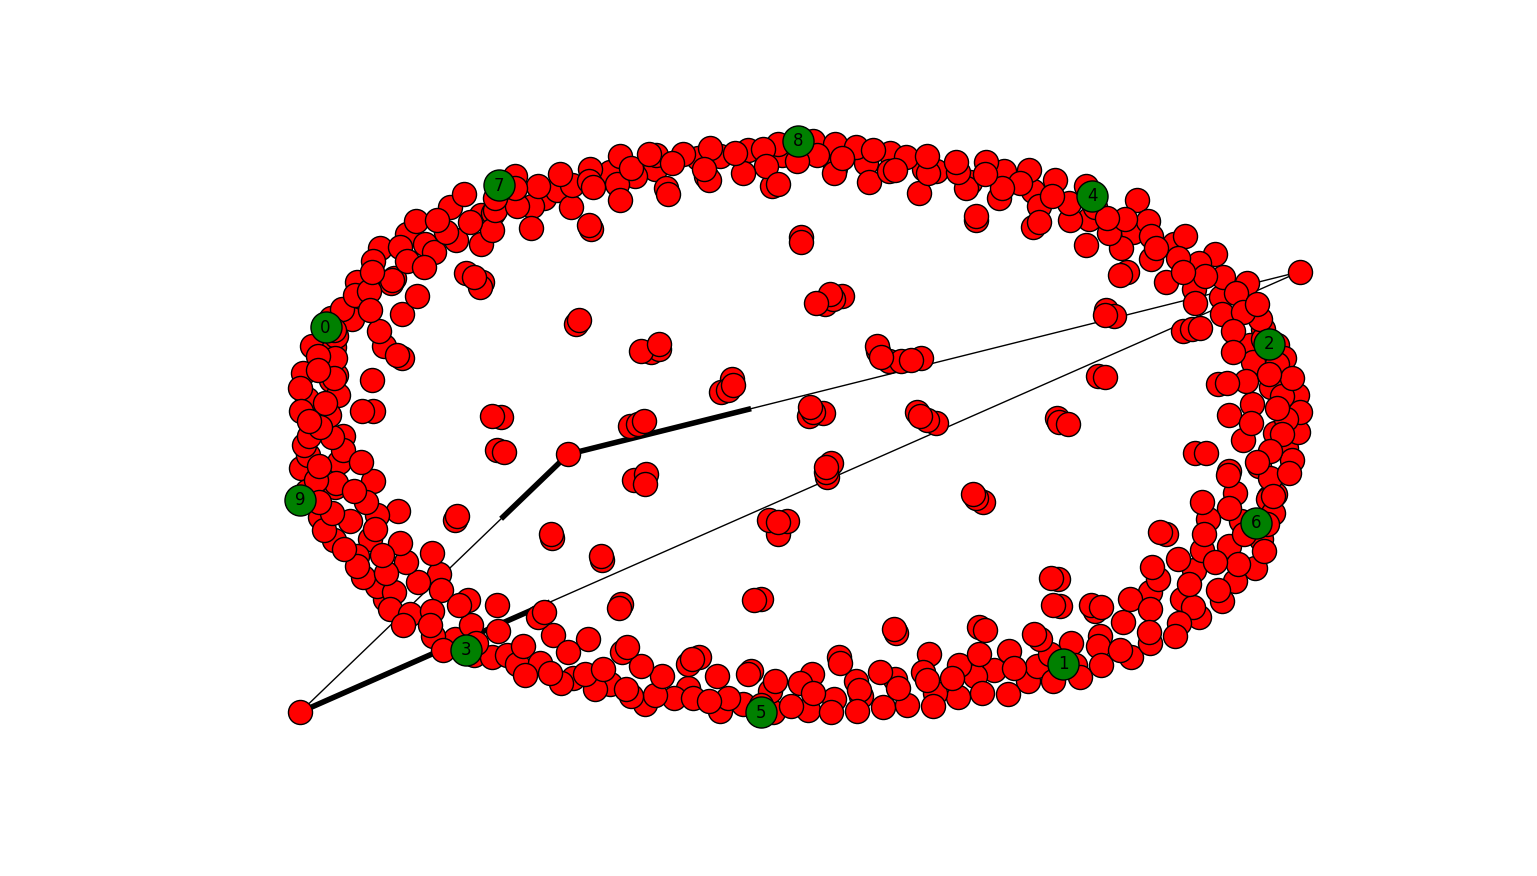

In [98]:
N=500
V = range(N)
G=nx.fast_gnp_random_graph(N,0.001)
nx.draw(G)

A = nx.adjacency_matrix(G)
print(A.todense())

g = nx.DiGraph([(1, 2), (2, 3), (1, 3)])
g.add_edge(3, 3)
print (nx.adjacency_matrix(g).todense())

nx.draw(g)


a = np.reshape(np.random.randint(1,size=100),(10,10))
D = nx.DiGraph(a)
nx.draw(D, node_size=500, with_labels=True, node_color='g')